<a href="https://colab.research.google.com/github/josesg998/redesn_2024/blob/main/Clase%202/Ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import sklearn.metrics
import keras
from keras.preprocessing.image import ImageDataGenerator

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Para descomprimir el archivo Neumonia.zip (Si se usa desde Colab)
# Creará dos carpetas:
#     "test"
#     "train"

!unzip "/content/drive/MyDrive/Neumonia.zip" -d "."
drive.flush_and_unmount()

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 extracting: ./train/neumonia/0281_bacteria.jpg  
 extracting: ./train/neumonia/0282_bacteria.jpg  
 extracting: ./train/neumonia/0283_bacteria.jpg  
  inflating: ./train/neumonia/0284_bacteria.jpg  
 extracting: ./train/neumonia/0285_bacteria.jpg  
  inflating: ./train/neumonia/0286_bacteria.jpg  
 extracting: ./train/neumonia/0287_bacteria.jpg  
 extracting: ./train/neumonia/0288_bacteria.jpg  
 extracting: ./train/neumonia/0289_bacteria.jpg  
  inflating: ./train/neumonia/0290_bacteria.jpg  
 extracting: ./train/neumonia/0291_bacteria.jpg  
 extracting: ./train/neumonia/0292_bacteria.jpg  
 extracting: ./train/neumonia/0293_bacteria.jpg  
 extracting: ./train/neumonia/0294_bacteria.jpg  
 extracting: ./train/neumonia/0295_bacteria.jpg  
 extracting: ./train/neumonia/0296_bacteria.jpg  
  inflating: ./train/neumonia/0297_bacteria.jpg  
  inflating: ./train/neumonia/0298_bacteria.jpg  
 extracting: ./train/neumonia/029

In [23]:
# Parámetros del notebook

# 224x244x3 (RGB) son las dimensiones que espera VGG16
width = 224   # ancho de las imágenes necesario para la arquitectura elegida
height = 224  # alto de las imágenes necesario para la arquitectura elegida
d_in = (height, width, 3)  # Dimensión de las imágenes de entradas

batch_size = 24  # Cantidad de imágenes por lote (para el entrenamiento)

train_folderpath = "train/"   # Directorio donde están las imágenes que se usaran en el entrenamiento
test_folderpath = "test/"     # Directorio donde están las imágenes que se usaran para la validación

d_out = 1     # Son dos clases, pero usamos codificación binaria (una única neurona de salida)

# Función de preprocesamiento de las imágenes (propia de cada arquitectura)
preprocessing_function = keras.applications.vgg16.preprocess_input

In [24]:
# Generadores
# El parámetro rescale se encarga de escalar los valores del rango [0..255] a [0..1]
train_datagen = ImageDataGenerator(rescale=1.0/255, preprocessing_function=preprocessing_function)
test_datagen = ImageDataGenerator(rescale=1.0/255, preprocessing_function=preprocessing_function)

print("Train data")
train_generator = train_datagen.flow_from_directory(
    train_folderpath, # directorio de donde cargar las imagenes (train)
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
    )

n_train = train_generator.samples

print("\n\nTest data")
test_generator = test_datagen.flow_from_directory(
    test_folderpath, # directorio de donde cargar las imagenes (test)
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

n_test = test_generator.samples

# Obtengo un diccionario donde "key" es el nombre de la clase (nombre del directorio) y "value" es el valor de la clase (0,1, etc.)
class_dict = train_generator.class_indices
print("\n\nCodificación de clases")
print(class_dict)

 # Construyo un diccionario donde "key" es el valor de la clase (0, 1, etc.) y "value" es el nombre de la clase (nombre del directorio)
class_dict_inverse = {}
for key in class_dict:
    value = class_dict[key]
    class_dict_inverse[value] = key

Train data
Found 5088 images belonging to 2 classes.


Test data
Found 256 images belonging to 2 classes.


Codificación de clases
{'neumonia': 0, 'normal': 1}


In [25]:
len(base_model.layers)

19

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

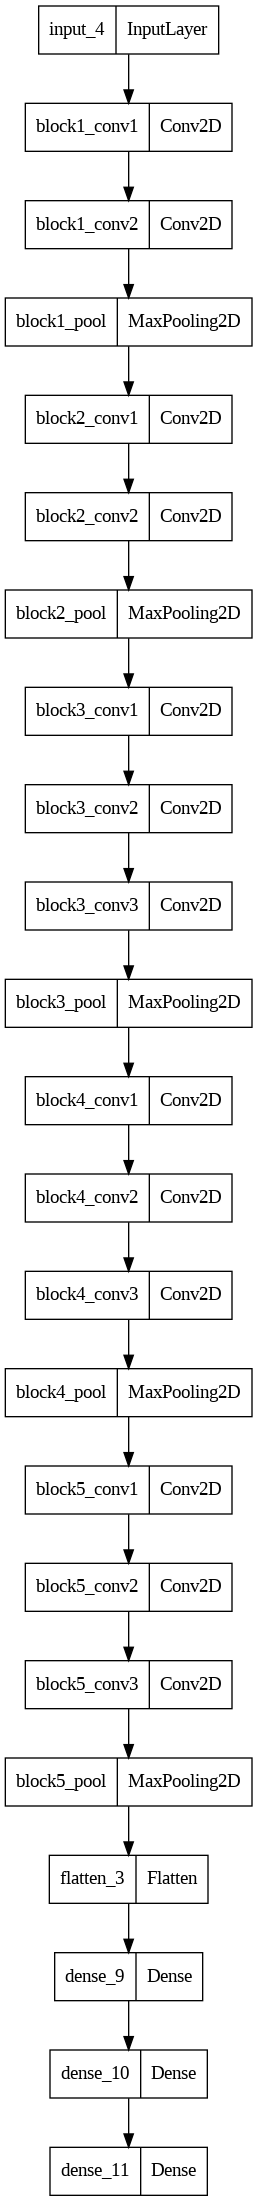

In [33]:
# Cargar el modelo preentrenado, puede usar cualquier arquitectura vista en clase, otra provista por keras o alguna otra creada por usted

base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=d_in,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# "Congelo" todas las capas del modelo original
#i=0
#for layer in base_model.layers:
#  i+=1
#  if i>19*.75:
#    layer.trainable = False

# Utilizar salida del modelo como entrada a una nueva capa
# Flatten
output = keras.layers.Flatten()(base_model.output)
# Dense de 4096
output = keras.layers.Dense(4096, activation= 'tanh')(output)
# Dense de 512
output = keras.layers.Dense(512, activation= 'tanh')(output)
# Nueva capa de salida
output = keras.layers.Dense(d_out, activation="softmax")(output)

model = keras.Model(inputs = base_model.input, outputs=output)

model.compile(
  optimizer = keras.optimizers.SGD(learning_rate=0.01),
  loss = 'binary_crossentropy', metrics = ['accuracy']
)

model.summary()
keras.utils.plot_model(model)

In [35]:
# Entrenar el modelo

epochs = 5
class_weight = { 0: 0.5,
                 1: 0.5 }

history = model.fit(train_generator, steps_per_epoch = n_train // batch_size,
                    epochs = epochs,  validation_data = test_generator, class_weight=class_weight
                    )

Epoch 1/5
212/212 [==============================] - 82s 388ms/step - loss: 0.1235 - accuracy: 0.2357 - val_loss: 0.1022 - val_accuracy: 0.5000
Epoch 2/5
212/212 [==============================] - 82s 386ms/step - loss: 0.0574 - accuracy: 0.2357 - val_loss: 0.0369 - val_accuracy: 0.5000
Epoch 3/5
 19/212 [=>............................] - ETA: 1:11 - loss: 0.0477 - accuracy: 0.2346

KeyboardInterrupt: 

In [28]:
# Hacer las predicciones con el conjunto de validación

test_generator.reset()
results = model.predict(test_generator)

11/11 [==============================] - 2s 164ms/step


In [29]:
# Imprimo resultados individuales

print('TRUE CLASS\tPREDICTED CLASS\tFILENAME')

test_file_names = test_generator.filenames
test_labels = test_generator.labels # clase de cada muestra de test

preds = np.zeros(results.shape)
aciertos = 0
for index, pred in enumerate(results):
    pred = np.round(pred)

    if (pred == test_labels[index]):
      aciertos = aciertos + 1

    pred_index = pred[0]
    pred_class = class_dict_inverse[pred_index]
    true_class = class_dict_inverse[test_labels[index]]
    file = test_file_names[index]
   # print(f'{true_class}\t{pred_class}\t{file}')

print(f"\n\n{aciertos} aciertos en {test_labels.shape[0]} muestras de test.")
print(f"Accuracy: {float(aciertos)/test_labels.shape[0]}")

TRUE CLASS	PREDICTED CLASS	FILENAME


128 aciertos en 256 muestras de test.
Accuracy: 0.5


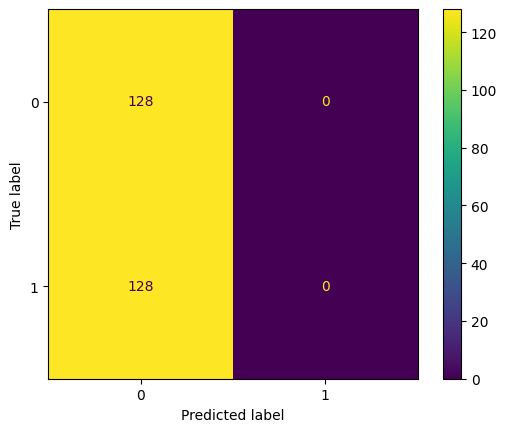

In [30]:
# Imprimo la matriz de confusión

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, preds)